In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tldextract
import seaborn as sns
import gender_guesser.detector as gender
import os

import wordcloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

print('Libraries imported!')

Libraries imported!


In [2]:
act_173=pd.read_csv('173.csv')
print(act_173.shape)

(3075031, 17)


# Part 1: Data Clean

### 1.1. Add one column 'ScrollDepth_count' (0/1). 

* 0: If there is NaN for ScrollDepth
* 1 if there is any number for ScrollDepth.

In [3]:
act_173.isnull().sum()

infinity_id           0
InfinityID            0
UUID                240
Brand                 0
Channel          124354
PageURL           12422
Author          1273826
Category              0
ArticleTitle     252910
Location         151583
Country            4454
HalTopics       3075031
HalKeyword       691468
RefererURL        34594
ScrollDepth     1962702
Browser               4
SessionID        562218
dtype: int64

Drop unuseful columns

In [4]:
act_173.drop(['HalTopics','SessionID','PageURL','infinity_id'], axis = 1, inplace = True)

In [5]:
act_173['ScrollDepth_count'] = 0
act_173.loc[act_173.ScrollDepth>0, 'ScrollDepth_count']=1
#result
act_173['ScrollDepth_count'].value_counts()

0    1962977
1    1112054
Name: ScrollDepth_count, dtype: int64

### 1.2. Add a new column called 'Referer', keeping only the company/brand information of  RefererURL. 
For example, if the RefererURL is https://www.google.com/, we only keep google in the Refer column.

In [6]:
#replace NaN with 'unknown'
act_173["RefererURL"] = act_173.RefererURL.fillna('unkown')
#convert to string type
act_173['RefererURL'] = act_173['RefererURL'].astype(str)
#replace // to blank 
act_173['RefererURL']= act_173["RefererURL"].apply(lambda x: "" if x=="//" else x)
#deal with abnormal format 'adroid_app...'
act_173['RefererURL'] = act_173['RefererURL'].apply(lambda x: 'android_app' if 'android-app'in x else x)
#extract domain using tldextract package
act_173['Referer'] = act_173['RefererURL'].apply(lambda x: tldextract.extract(x).domain if 'http' in x else x)
#drop referel url
act_173.drop('RefererURL', axis= 1,inplace=True)

### 1.3. Transform Channel to lower case

In [7]:
act_173.Channel = act_173.Channel.fillna('unkown')
act_173['Channel'] = act_173['Channel'].apply(lambda x: x.lower())

### 1.4. Fill in missing values for Country, Location,Channel, ArticleTitle and HalKeyword

In [8]:
act_173['Country'].fillna('United States', inplace=True)
act_173['Location'].fillna('unknown',inplace=True)
act_173['Channel'].fillna('unknown',inplace=True)
act_173['HalKeyword'].fillna('', inplace =True)
act_173['ArticleTitle'].fillna('',inplace=True)
act_173.UUID.fillna('', inplace=True)

### 1.5. Add new column "first author"

In [9]:
act_173['Author'] = act_173['Author'].fillna('[]')
act_173.Author = act_173.Author.apply(lambda x:x.lower())
act_173['Author'] = act_173['Author'].map(lambda x: x.lstrip('[').rstrip(']'))
newDF = act_173['Author'].str.split(',',3,True)
newDF.columns = ['Author1', 'Author2','Author3','Author4']

In [10]:
act_173_new = pd.concat([act_173,newDF],axis=1,ignore_index=False)
act_173_new.drop(['Author2','Author3','Author4'],axis = 1,inplace = True)

In [11]:
act_173_new.isnull().sum()

InfinityID                 0
UUID                       0
Brand                      0
Channel                    0
Author                     0
Category                   0
ArticleTitle               0
Location                   0
Country                    0
HalKeyword                 0
ScrollDepth          1962702
Browser                    4
ScrollDepth_count          0
Referer                    0
Author1                    0
dtype: int64

### 1.6. Add new column "gender" , showing gender information of first author (newly added)

In [12]:
d = gender.Detector()

In [13]:
author_gender=[]
for i in act_173_new['Author1']:
    i= i.split()
    if len(i)>1:
        first_name= i[0].lstrip("'")
        ag = d.get_gender(first_name.capitalize())
        author_gender.append(ag)
    else:
        author_gender.append('unknown')

act_173_new['gender']=author_gender

In [14]:
act_173_new["gender"].value_counts()

unknown          1533596
female            869047
male              416896
mostly_female     168321
mostly_male        45479
andy               41692
Name: gender, dtype: int64

Chi-square test for gender and scrolldepth_count

In [15]:
contingency_table= pd.crosstab(act_173_new['gender'],act_173_new['ScrollDepth_count'])
contingency_table= contingency_table[0:5] #exclude unknown
contingency_table

ScrollDepth_count,0,1
gender,,
andy,18569,23123
female,417875,451172
male,231466,185430
mostly_female,75615,92706
mostly_male,28771,16708


In [16]:
contingency_table.values

array([[ 18569,  23123],
       [417875, 451172],
       [231466, 185430],
       [ 75615,  92706],
       [ 28771,  16708]], dtype=int64)

In [17]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
stat, p, dof, expected = chi2_contingency(contingency_table)
print('dof=%d' % dof)
print(expected)

dof=4
[[ 20888.69451647  20803.30548353]
 [435413.44390908 433633.55609092]
 [208874.92058763 208021.07941237]
 [ 84332.86840898  83988.13159102]
 [ 22786.07257783  22692.92742217]]


In [18]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent, reject H0')
else:
    print('Independent, fail to reject H0')

probability=0.950, critical=9.488, stat=11785.341
Dependent, reject H0


In [19]:
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent, reject H0')
else:
    print('Independent, fail to reject H0')

significance=0.050, p=0.000
Dependent, reject H0


In [20]:
contingency_table[1]/(contingency_table[0]+contingency_table[1])*100

gender
andy             55.461479
female           51.915719
male             44.478719
mostly_female    55.076907
mostly_male      36.737835
dtype: float64

#### Conclusion: 
* We reject the null hypothesis at the 1% significance level
* We infer that in the population, whether people click or not do differ by the gender of the authors.
* Article written by female(/mostly female) writers are more likely to be clicked than male(or mostly male). This also means that we can include gender information in modeling when predicting click or not.

### 1.7 Delete scroll depth < 0

In [21]:
act_173_new['ScrollDepth'] = act_173_new['ScrollDepth'].fillna(0)

In [22]:
act_173_new = act_173_new[act_173_new['ScrollDepth']>=0]

In [23]:
len(act_173_new)

3074756

#### Now we have a clean set for analysis:

In [24]:
act_173_new.isnull().sum()

InfinityID           0
UUID                 0
Brand                0
Channel              0
Author               0
Category             0
ArticleTitle         0
Location             0
Country              0
HalKeyword           0
ScrollDepth          0
Browser              4
ScrollDepth_count    0
Referer              0
Author1              0
gender               0
dtype: int64

# Part 2: Devide into Different Bins
In order to realize replication

In [25]:
np.random.seed(123)

Randomly select 20000 rows

In [26]:
df = act_173_new.sample(n=20000)
df.reset_index(inplace= True)
df.shape

(20000, 17)

In [27]:
print(df["ScrollDepth"].max(), df["ScrollDepth"].mean())

136400.0 3110.76


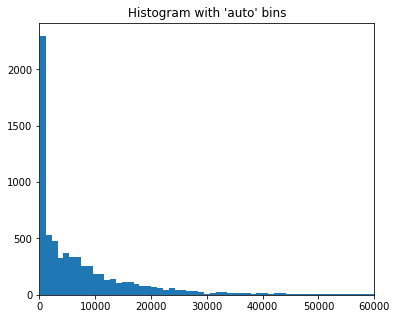

In [28]:
plt.figure(figsize=(6,5))
plt.hist(df[df['ScrollDepth']>0].ScrollDepth , bins='auto')  
plt.title("Histogram with 'auto' bins")
plt.xlim(0, 60000)
plt.show()

### 2.1 Add cut_q: qcut ('ScrollDepth']>0): divide up the underlying data into equal sized bins. (quantile cut)

In [29]:
df1=df[df['ScrollDepth']>0] 
labels=['1','2','3','4']
pd.qcut(df1['ScrollDepth'], 4).cat.categories

IntervalIndex([(99.999, 700.0], (700.0, 4200.0], (4200.0, 10900.0], (10900.0, 136400.0]],
              closed='right',
              dtype='interval[float64]')

In [30]:
df1['cut_q'] = pd.qcut(df1['ScrollDepth'], 4, labels=labels)

In [31]:
df['cut_q']=df1['cut_q']
cut_q_without_na = df['cut_q'].cat.add_categories('0').fillna('0')
cut_q_without_na = cut_q_without_na.cat.reorder_categories(new_categories=['0', '1', '2', '3', '4'],ordered=True)
cut_q_without_na.cat.categories

Index(['0', '1', '2', '3', '4'], dtype='object')

In [32]:
df['cut_q'] = cut_q_without_na
df['cut_q'].value_counts()

0    12762
1     1939
3     1811
4     1794
2     1694
Name: cut_q, dtype: int64

In [33]:
dic_cut_q= {'0': 'No value', '1': '99.999-700.0', '2': '700.0-4200.0', '3':'4200.0-10900.0', '4':'10900.0-136400.0'}
dic_cut_q

{'0': 'No value',
 '1': '99.999-700.0',
 '2': '700.0-4200.0',
 '3': '4200.0-10900.0',
 '4': '10900.0-136400.0'}

### 2.2 Add cut_d: cut base on the distance of each bin (pd.cut)

In [34]:
df.head(n=3)

,index,InfinityID,UUID,Brand,Channel,Author,Category,ArticleTitle,Location,Country,HalKeyword,ScrollDepth,Browser,ScrollDepth_count,Referer,Author1,gender,cut_q
0,2241400,ba825bbc-9a1c-4661-8256-fcee9595c0c9,d589330e-8acd-47ce-b60b-d80a871dddd0,bon-appetit,recipes,'bon appétit',general,55 Bean Recipes You'll Be Making All Year Long,White Plains,United States,bean,0.0,Mobile Safari,0,google,'bon appétit',andy,0
1,1292526,6b7105d9-5787-45ab-8496-86e88ac74cc2,b1a6872b-4af3-4016-8b7f-231578e9b198,epicurious,recipes,,general,CABBAGE SOUP ETC,Wantagh,United States,,0.0,Chrome Mobile,0,android_app,,unknown,0
2,2478318,cde2d845-1a2b-45f5-97fa-e4621e294140,4ae1ced9-4b3a-4827-9653-04e0563cf542,vanity-fair,news,'tina nguyen',general,"Nancy Pelosi Pulls Rank, Suspends Trump’s Stat...",Asbury Park,United States,"nancy pelosi,state of the union address,donald...",0.0,Mobile Safari UI/WKWebView,0,facebook,'tina nguyen',female,0


# Part 3 Article Title and HalKeyword Features Extraction
### 3.1 clean title

In [35]:
# removing everything except alphabets`
act_173_new['clean_title'] = act_173_new['ArticleTitle'].str.replace("[^a-zA-Z#]", " ")
# removing short words
act_173_new['clean_title'] = act_173_new['clean_title'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# make all text lowercase
act_173_new['clean_title'] = act_173_new['clean_title'].apply(lambda x: x.lower())

### 3.2 clean keyword

In [36]:
# removing everything except alphabets`
act_173_new['clean_keyword'] = act_173_new['HalKeyword'].str.replace("[^a-zA-Z#]", " ")
# removing short words
act_173_new['clean_keyword'] = act_173_new['clean_keyword'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# make all text lowercase
act_173_new['clean_keyword'] = act_173_new['clean_keyword'].apply(lambda x: x.lower())

In [37]:
act_173_new.drop(['ArticleTitle','HalKeyword'], axis= 1, inplace=True)

combine title and keyword to one column

In [38]:
act_173_new['text']= act_173_new['clean_title'] + ' ' + act_173_new['clean_keyword']
act_173_new.head()

,InfinityID,UUID,Brand,Channel,Author,Category,Location,Country,ScrollDepth,Browser,ScrollDepth_count,Referer,Author1,gender,clean_title,clean_keyword,text
0,00000fa3-c23a-4f68-9f45-4ed4762546f7,jj8PvuxZra52k98JGtBgHtM62YxZYij1eZAQ6a85SEphZq...,brides,registry,,amp,La Mesa,United States,0.0,Mobile Safari,0,google,,unknown,honeymoon registry sites brides should know,,honeymoon registry sites brides should know
1,00004d7b-7dcf-4f46-b182-fbea50cdc944,D3MzT5UmCJUcHHohAi3G7nkAOb8sPff4wIjGo3U5Y4H5uy...,vanity-fair,hollywood,,amp,Tulsa,United States,0.0,Mobile Safari,0,google,,unknown,crown queen elizabeth surprising downton abbey...,,crown queen elizabeth surprising downton abbey...
2,00005714-7c5d-4dbd-87c3-b8b8ed9f5210,861f40d5-82e3-4e34-b935-ea839232e786,vogue,beauty,'jenna rennert',general,Broken Arrow,United States,0.0,Facebook,0,facebook,'jenna rennert',female,best body lotions restore hydrate smooth skin,lotion supercharged self care shea butter exfo...,best body lotions restore hydrate smooth skin ...
3,00006751-5292-43d2-8b24-e94c52a64cb3,44ee0aca-7af1-49fc-98af-d672eef7d76a,allure,skin,'sarah kinonen',general,Richmond,United States,1100.0,Mobile Safari,1,google,'sarah kinonen',female,earlobe reconstruction surgery repair stretche...,earlobe lobe sandra reconstruction surgery,earlobe reconstruction surgery repair stretche...
4,00006751-5292-43d2-8b24-e94c52a64cb3,f4514104-6715-4f4f-bc5b-04ed8826419f,allure,skin,'sarah kinonen',general,Richmond,United States,0.0,Mobile Safari,0,google,'sarah kinonen',female,earlobe reconstruction surgery repair stretche...,earlobe lobe sandra reconstruction surgery,earlobe reconstruction surgery repair stretche...


In [42]:
act_173_new.to_csv("173_clean.csv",index=False,header=True)

# Part 4 Prepare AUC data and COEFF data

In [47]:
csv_dir = 'auc_table/'
file_list = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir)]
auc = []
for l in file_list:
    data = pd.read_csv(l)
    auc.append(data)
auc = pd.concat(auc)

In [48]:
csv_dir = 'model_coef/'
file_list = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir)]
coeff = []
for l in file_list:
    data = pd.read_csv(l)
    coeff.append(data)
coeff = pd.concat(coeff)

In [49]:
auc.head

<bound method NDFrame.head of           Date                           model  \
0   2019-03-26   best model for regparam=1e-06   
1   2019-03-26   best model for regparam=1e-05   
2   2019-03-26  best model for regparam=0.0001   
3   2019-03-26   best model for regparam=0.001   
4   2019-03-26    best model for regparam=0.01   
5   2019-03-26             best model regparam   
6   2019-03-26    model auc for best reg param   
7   2019-03-26          best model on training   
8   2019-03-26      best model on full dataset   
9   2019-03-26      best model on all us users   
0   2019-01-10   best model for regparam=1e-06   
1   2019-01-10   best model for regparam=1e-05   
2   2019-01-10  best model for regparam=0.0001   
3   2019-01-10   best model for regparam=0.001   
4   2019-01-10    best model for regparam=0.01   
5   2019-01-10             best model regparam   
6   2019-01-10    model auc for best reg param   
7   2019-01-10          best model on training   
8   2019-01-10      

In [50]:
coeff.head

<bound method NDFrame.head of             Date                                           variable  \
0     2019-03-26                                        topic_0_bin   
1     2019-03-26                                        topic_1_bin   
2     2019-03-26                                       topic_10_bin   
3     2019-03-26                                      topic_100_bin   
4     2019-03-26                                      topic_101_bin   
5     2019-03-26                                      topic_102_bin   
6     2019-03-26                                      topic_103_bin   
7     2019-03-26                                      topic_104_bin   
8     2019-03-26                                      topic_105_bin   
9     2019-03-26                                      topic_106_bin   
10    2019-03-26                                      topic_107_bin   
11    2019-03-26                                      topic_108_bin   
12    2019-03-26                               

In [51]:
auc.to_csv("auc.csv",index=False,header=True)
coeff.to_csv("coeff.csv", index = False, header = True)